In [13]:
!pip install pyreadstat
import pandas as pd
import pyreadstat as prs
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [15]:
#Load the data
df, meta = prs.read_sav("/content/drive/My Drive/Tab18-1.sav")

In [16]:
df

,WEEK0,WEEK3,WEEK6,WEEK9,WEEK12
0,6.0,10.0,8.0,4.0,5.0
1,2.0,4.0,8.0,5.0,6.0
2,2.0,4.0,8.0,5.0,5.0
3,4.0,5.0,8.0,10.0,7.0
4,4.0,7.0,9.0,7.0,11.0
5,5.0,7.0,9.0,7.0,7.0
6,2.0,9.0,11.0,8.0,7.0
7,6.0,9.0,11.0,8.0,8.0
8,13.0,10.0,11.0,8.0,8.0
9,7.0,3.0,11.0,8.0,11.0


In [17]:
#Repeated Measures ANOVA 
def repeated_measures_anova(data):

  #Calculate grand mean
  sum_x = 0
  for column in data.columns:
    sum_x += sum(data[column])

  grand_mean = sum_x / sum(data.count())

  #Calculate sums of squares
  #SS Total
  ss_total = 0
  for column in data.columns:
    for value in data[column]:
      ss_total += (value-grand_mean)**2

  #SS Subject
  ss_subject = 0
  count = 0
  for subject in data.values:
    ss_subject += (data.values[count].mean()-grand_mean)**2
    count += 1
  ss_subjects = ss_subject*len(data.columns)

  #SS Week
  ss_week = 0
  for week in df.columns:
    ss_week += (df[week].mean()-grand_mean)**2
  ss_weeks = ss_week*len(df)

  #SS Error
  ss_error = ss_total - ss_subjects - ss_weeks


  # Degrees of Freedom
  df_subjects = len(df)-1
  df_weeks = len(df.columns)-1
  df_error = df_subjects*df_weeks
  df_total = sum(df.count()) - 1


  #MS
  ms_weeks = ss_weeks/df_weeks
  ms_error = ss_error/df_error


  #F-test & p-value
  F = ms_weeks/ms_error
  p_value = stats.f.sf(F,df_weeks,df_error,loc=0,scale=1)

  #result table
  results = {"SS":[ss_subjects, ss_weeks, ss_error, ss_total],
           "df":[df_subjects, df_weeks, df_error, df_total],
           "MS":["", ms_weeks, ms_error,""],
           "F":["", F, "", ""],
            "P-Value":["", p_value, "", ""]}
  columns=["SS", "df", "MS", "F", "P-Value"]
  result_table = pd.DataFrame(results, columns=columns, index = ["Subjects", "Weeks", "Error", "Total"])

  return result_table

In [ ]:
#Run Repeated Measures ANOVA
repeated_measures_anova(df)

,SS,df,MS,F,P-Value
Subjects,1375.712,24,,,
Weeks,121.152,4,30.288,6.40383,0.000130405
Error,454.048,96,4.72967,,
Total,1950.912,124,,,


In [18]:
#Create a dataframe as input for the cross-validation function of sklearn
rm_dict = {}
rm_dict["Subject"] = []
rm_dict["Week"] = []
rm_dict["Depression"] = []

for n in range(len(df)):
  for m in df.columns:
    rm_dict["Subject"].append(df.index[n])
    rm_dict["Week"].append(m)
    rm_dict["Depression"].append(df[m][n])

rm_df = pd.DataFrame(rm_dict)

In [ ]:
rm_df.head(10)

,Subject,Week,Depression
0,0,WEEK0,6.0
1,0,WEEK3,10.0
2,0,WEEK6,8.0
3,0,WEEK9,4.0
4,0,WEEK12,5.0
5,1,WEEK0,2.0
6,1,WEEK3,4.0
7,1,WEEK6,8.0
8,1,WEEK9,5.0
9,1,WEEK12,6.0


In [22]:
#Function to compare 2 models (RM ANOVA)
def compare_models(x, y, folds, groups, repetitions):

  #Prediction by Mean (to pass to Sklearn’s cross-validation)  
  class MeanPredictor():

      def __init__(self, mean=None):
        if mean is not None:
          self.mean =mean
        else:
          self.mean=None

      def fit(self, X, Y):
        self.mean = np.mean(Y)

      def predict(self, X):
        return np.full(X.shape[0], self.mean)

      def get_params(self, deep=False):
        return {"mean":self.mean}
  
  #Initiate list container for the results and win count
  result_list = []
  win_count = 0

  #Creat dummy variables for Regression
  X = pd.get_dummies(x)

  #For every repetition run cross-validation with mean & factor model
  #Note: GroupShuffleSplit is just a splitter. By setting the test_size equal
  #to 0.1 for 10 folds, and 0.2 for 5 folds, we get a 10-fold or 5-fold cv,
  #respectively.
  if folds == 10:
    test_size = 0.1
  else:
    test_size = 0.2
  
  for n in range(repetitions):
    gss = GroupShuffleSplit(n_splits=folds, test_size=test_size, random_state=n)

    score1 = np.sqrt(cross_val_score(MeanPredictor(), X, y, groups = groups,
                                    scoring='neg_mean_squared_error', cv=gss, 
                                    n_jobs=-1).mean()*-1)

    score2 = np.sqrt(cross_val_score(LinearRegression(), X, y, groups = groups,
                                    scoring='neg_mean_squared_error', cv=gss, 
                                    n_jobs=-1).mean()*-1)

    #Count the winning model
    if score1 < score2:
      result_list.append([score1, 1, score2, 0])
      win_count += 1

    elif score1 > score2:
      result_list.append([score1, 0, score2, 1])
      win_count -=1

    else:
      result_list.append([score1, 1, score2, 1])

  #Print the winner (if there is one)
  if win_count > 0:
     print(f"Prediction by Mean wins in {win_count/repetitions*100}% of all repetitions!")

  elif win_count < 0:
    print(f"Factor Model wins in {win_count/repetitions*-100}% of all repetitions!")

  else:
    print("Models are even")
  
  #Create a dataframe of the RMSEs and the Wins for each model
  column_names = ["Prediction by Mean", "Win1", "Factor Model", "Win2"]
  df_list=pd.DataFrame(result_list, columns=column_names)
  df_list.index += 1 
  
  return df_list

In [23]:
#Run the analysis with cross-validation
comparison_rm = compare_models(rm_df["Week"], rm_df["Depression"], 
                               groups=rm_df["Subject"], folds=5, 
                               repetitions=100)

Factor Model wins in 92.0% of all repetitions!


AxesSubplot(0.125,0.125;0.775x0.755)


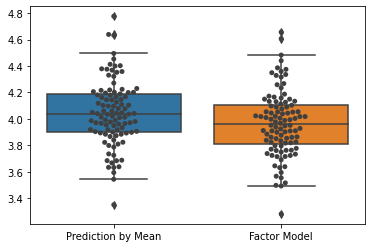

In [24]:
#Create box plot to compare RMSE of both models
def plot_rmse(df):

  plt.figure()
  box_df = df[["Prediction by Mean", "Factor Model"]]
  box = sns.boxplot(data = box_df)
  box = sns.swarmplot(data = box_df, color=".25")
  print(box)

plot_rmse(comparison_rm)